In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st


from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

### Custom Loss

In [2]:
def TwoCUM_batch(E, Fp ,vp, AIF1 , t): 
    batch_size = E.shape[0]
    
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t[:,None]/Tp[None,:]) #adding dummy variables so it divides properly

    R=exptTp*(1-E) + E

    #Calculate the convolution
    R = torch.flip(R, (0,)).T #Reshape to fit the the convolution
    R = torch.unsqueeze(R, 1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF1.shape[2]-1).view(batch_size, -1)
    F = Fp.unsqueeze(-1)*temp[:,0:len(t)] #unsqueeze to match dimensions
    return F

def loss_fn_batch(outputs, targets):
    #E, Fp, vp
    #time spacings
    t = np.arange(0,366,2.45)
    t = torch.tensor(t)
    
    batch_size = outputs[:,0].shape[0]
    AIF = torch.from_numpy(np.load("data/AIF.npy"))
    AIF1 = AIF.view(1, 1, -1) #reshaped for convolution

    
    #For outputs
    #First calculate the parameter Tp
    E, Fp ,vp = outputs[:,0], outputs[:,1], outputs[:,2]
    F_out = TwoCUM_batch(E, Fp ,vp, AIF1, t)

    
    #For targets - copy pasted
    E_true, Fp_true ,vp_true = targets[:,0], targets[:,1], targets[:,2]
    F_targets = TwoCUM_batch(E_true, Fp_true ,vp_true, AIF1, t)

    
    MSE = torch.sum((F_out - F_targets)**2)/F_out.shape[1]
    return MSE

def combined(outputs, targets):
    MSE_comb = loss_fn_batch(outputs, targets) + 50*torch.sum((outputs - targets)**2)

    return MSE_comb

### Distributions

In [3]:
def E_distribution(num):
    p = 0.09392265193370165
    params = (69.70266807226483, 1.0792465008741048, -0.23357477054649745, 0.08955766184221467)
    start_nums = int(p*num)
    
    start = np.random.uniform(low = 0, high= 0.001, size = start_nums)
    
    dist_num = num - start_nums
    gen_data_Fp = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    gen_data_Fp = np.array(gen_data_Fp)
    
    true_dist = np.concatenate((start, gen_data_Fp), axis=None)
    
    true_dist[true_dist < 0] = 0.0001

    
    
    return true_dist

def Fp_distribution(num):
    p = 0.1182
    params = (1.064799958220838, 0.0005001496965058328, 0.007151833882619035)
    start_nums = int(p*num)
    
    start = np.random.uniform(low = 0, high= 0.0005, size = start_nums)
    
    dist_num = num - start_nums
    gen_data_Fp = st.weibull_min.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_Fp = np.array(gen_data_Fp)
    
    true_dist = np.concatenate((gen_data_Fp, start), axis=None)
    #true_dist[true_dist > 1] = 0.99

    
    
    return true_dist

def vp_distrubition(num):
    params = (29572479.030125827, 6450136.935704315, 6450136.715197781)
    p = 0.287
    endnum = int(p*num)
    end = np.random.uniform(low = 0.98, high= 0.99, size = endnum)
    
    dist_num = num - endnum
    gen_data_vp = st.weibull_max.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_vp = np.array(gen_data_vp)
    
    true_dist = np.concatenate((gen_data_vp, end), axis=None)
    true_dist[true_dist > 1] = 0.99
    true_dist[true_dist < 0] = 0.011

    
    
    return true_dist

### Create Dataloader and Dataset

In [4]:
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    #E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    #vp = np.random.rand(1,num_curves)
    #Fp = np.random.rand(1,num_curves) #this will be multplied by 1e-5 to get the right scale at the end
    
    E = E_distribution(num_curves) 
    Fp = Fp_distribution(num_curves)
    vp = vp_distrubition(num_curves)

    E = E[None,:]
    Fp = Fp[None,:]
    vp = vp[None,:]



    
    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y


def create_dataloader(x, y, batch_size):
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()

    
    torch_dataset = Data.TensorDataset(x, y) 

    dataloader = Data.DataLoader(torch_dataset, batch_size=batch_size, shuffle=True) 
    
    return dataloader




### Define Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 1000) 
        self.bn1 = nn.BatchNorm1d(1000)
        self.hidden2 = torch.nn.Linear(1000, 200) 
        self.bn2 = nn.BatchNorm1d(200)
        self.hidden3 = torch.nn.Linear(200, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.hidden4 = torch.nn.Linear(200, 200)
        self.bn4 = nn.BatchNorm1d(200)
        self.hidden5 = torch.nn.Linear(200, 200)
        self.bn5 = nn.BatchNorm1d(200)
        self.predict = torch.nn.Linear(200, 3)
        self.bound = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.hidden(x)) )     
        x = F.relu(self.bn2(self.hidden2(x)))
        x = F.relu(self.bn3(self.hidden3(x)))
        x = F.relu(self.bn4(self.hidden4(x)))
        x = F.relu(self.bn5(self.hidden5(x)))
        x = self.predict(x) 
        x = self.bound(x)
        return x

net = Net()

### Training Steps

In [6]:
def train(model, x, y, optimiser, criterion):
    model.train()
    model.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimiser.step()
       
    return loss, output

def test(model, x, y, criterion):
    with torch.no_grad():
        model.eval()
        output = model(x)
        loss = criterion(output, y)

    return loss, output

def normalise(x):
    x_trans = ( (x - x.mean() )/ x.std())
    return x_trans

### Run Training

In [7]:
#generate and normalise data
#training set
num_curves = 10000
x,y = generate_xy(num_curves)
x = normalise(x)

#validation set
x_val,y_val = generate_xy(int(num_curves/3))
x_val = normalise(x_val)


In [8]:

epochs = 200
batch_size = 50
optimiser = optimiser = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

criterion = combined
loss_plot = np.empty(epochs)
loss_val_plot = np.empty(epochs)

dataloader = create_dataloader(x, y, batch_size)
dataloader_val = create_dataloader(x_val, y_val, batch_size*5)
for epoch in range(epochs):

    for i, (train_x, train_y) in enumerate(dataloader):
        loss, predictions = train(net, train_x, train_y, optimiser, criterion)
    
    for i, (val_x, val_y) in enumerate(dataloader_val):
        loss_val, predictions_val = test(net, val_x, val_y, criterion)
        
    if epoch % 1 == 0:
        print(epoch)
        
    loss_plot[epoch] = loss.detach().numpy() 
    loss_val_plot[epoch] = loss_val.detach().numpy()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


4.284515565852199 1073.0370374790248
nan nan


Text(0, 0.5, 'Loss')

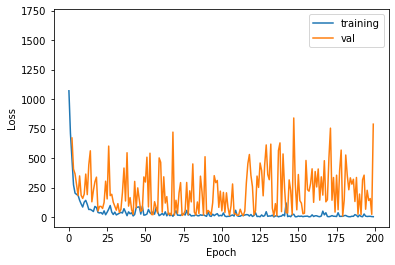

In [9]:
print(loss_plot.min(), loss_plot.max())
print(loss_val_plot.min(), loss_val_plot.max())

plt.plot(loss_plot, label = 'training')
plt.plot(loss_val_plot, label = 'val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Testing
##### Tested using the training data (usually use a seperate testing dataset)

In [10]:
def plot_curves(prediction, target, AIF, t):
    predicted_curve = TwoCUM(prediction.detach().numpy(), t, AIF, 0)
    target_curve = TwoCUM(target.detach().numpy(), t, AIF, 0)
    
    plt.plot(t, predicted_curve, label = 'Prediction')
    plt.plot(t, target_curve, label = 'Target')
    plt.legend()
    plt.show()

tensor([[-0.9948, -0.9951, -0.9953,  ..., -0.3673, -0.3669, -0.3652],
        [-0.9987, -1.0001, -1.0013,  ...,  1.6538,  1.6696,  1.6952],
        [-0.9984, -1.0001, -1.0017,  ...,  1.8987,  1.9049,  1.9210],
        ...,
        [-1.0101, -1.0127, -1.0148,  ...,  3.3625,  3.3957,  3.4623],
        [-0.9944, -0.9945, -0.9945,  ..., -0.7847, -0.7837, -0.7825],
        [-0.9962, -0.9970, -0.9978,  ...,  0.8776,  0.8767,  0.8803]])

 test


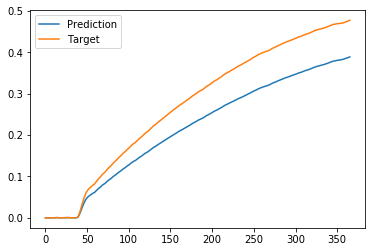

prediction:  [8.959342e-02 7.446159e-04 9.952094e-01] 
true:  [0.07643642 0.0009985  0.80253506]

 train


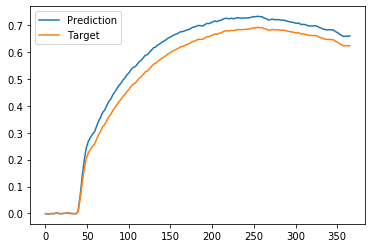

prediction:  [0.04693501 0.00408295 0.4254797 ] 
true:  [0.00072833 0.00339447 0.4441334 ]

 val


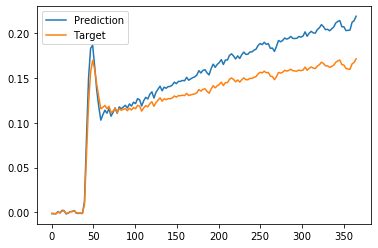

prediction:  [0.05383952 0.00544    0.02969182] 
true:  [0.05098706 0.00410891 0.03559267]


In [13]:
AIF = np.load("data/AIF.npy")
t = np.arange(0,366,2.45)

xt,yt = generate_xy(100)

xt = normalise(xt)

dataloader_test = create_dataloader(xt, yt, 50)


for i, (test_x, test_y) in enumerate(dataloader_test):
    j = np.random.randint(0 ,test_x.shape[0])
    prediction_test = net(test_x)
    print(test_x)
    print('\n test')
    plot_curves(prediction_test[j], test_y[j], AIF, t)
    print('prediction: ', prediction_test[j].detach().numpy(),'\ntrue: ', test_y[j].detach().numpy())
    
    break
    
for i, (train_x, train_y) in enumerate(dataloader):
    j = np.random.randint(0 ,train_x.shape[0])
    prediction = net(train_x)
    print('\n train')

    plot_curves(prediction[j], train_y[j], AIF, t)
    print('prediction: ',prediction[j].detach().numpy(), '\ntrue: ',train_y[j].detach().numpy())
        
    break
    
for i, (val_x, val_y) in enumerate(dataloader_val):
    j = np.random.randint(0 ,val_x.shape[0])
    prediction_val = net(val_x)
    print('\n val')

    plot_curves(prediction_val[j], val_y[j], AIF, t)
    print('prediction: ',prediction_val[j].detach().numpy(), '\ntrue: ',val_y[j].detach().numpy())
        
    break

### Results log


In [15]:
AIF = np.load("data/AIF.npy")
series = np.load("data/Example_Conc.npy")

(2, 150) (2, 3)
torch.Size([2, 150])
torch.Size([2, 3])

 real


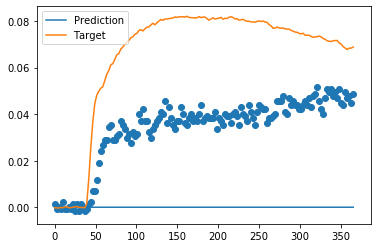

prediction:  [6.5698517e-03 7.6737159e-09 1.0000000e+00] 
true:  [0.04385121 0.0007764  0.04      ]


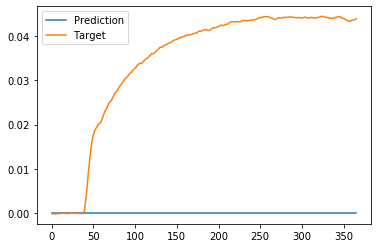

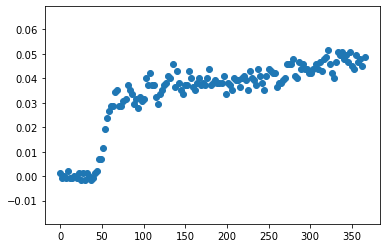

prediction:  [1.8635223e-04 1.0978986e-32 1.0000000e+00] 
true:  [0.13459004 0.00029181 0.02      ]


<Figure size 432x288 with 0 Axes>

In [16]:
t = np.arange(0,366,2.45)
i = 112
j = 80
k = 10
points1 = series[i:i+2,j,k,:]

xpoints = normalise(points1)
#prediction_points = net(xpoints)
fitted_param1 = TwoCUMfittingConc(t, AIF, series[i,j,k,:] , 0)
fitted_param2 = TwoCUMfittingConc(t, AIF, series[i+1,j,k,:] , 0)
fitted_param1 = fitted_param1[None,:3]
fitted_param2 = fitted_param2[None,:3]
ypoints = np.concatenate((fitted_param1, fitted_param2), axis = 0)

print(xpoints.shape, ypoints.shape)
dataloader_real = create_dataloader(xpoints, ypoints, 2)

for i, (test_x, test_y) in enumerate(dataloader_real):
    print(test_x.shape)
    prediction_test = net(test_x)
    print(prediction_test.shape)
    print('\n real')
    
    predicted_curve = TwoCUM(prediction_test[0].detach().numpy(), t, AIF, 0)
    target_curve = TwoCUM(test_y[0].detach().numpy(), t, AIF, 0)
    plt.plot(t, predicted_curve, label = 'Prediction')
    plt.plot(t, target_curve, label = 'Target')
    plt.legend()
    plt.scatter(t, points1[1,:])

    plt.show()
    plt.clf()
    print('prediction: ', prediction_test[0].detach().numpy(),'\ntrue: ', test_y[0].detach().numpy())
    
    plot_curves(prediction_test[1], test_y[1], AIF, t)
    plt.scatter(t, points1[1,:])
    plt.show()
    plt.clf()
    print('prediction: ', prediction_test[1].detach().numpy(),'\ntrue: ', test_y[1].detach().numpy())
    
    break

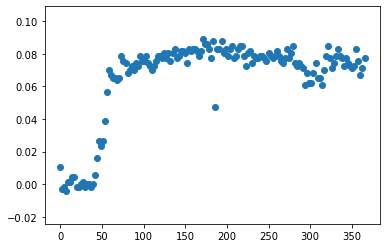

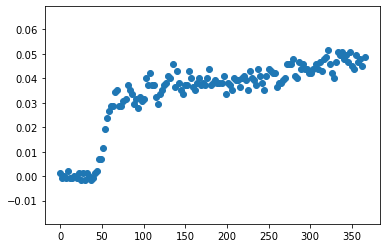

ValueError: All-NaN slice encountered

<Figure size 432x288 with 0 Axes>

In [17]:

plt.scatter(t, points1[0,:])
plt.show()
plt.clf()

plt.scatter(t, points1[1,:])
plt.show()
plt.clf()

fitted_param = TwoCUMfittingConc(t, AIF, series[i,j,k,:] , 0)
pos = np.random.choice(np.arange(len(keys)))
parameters = para_dict[keys[pos]]
pk = np.array(parameters)
predicted_curve = TwoCUM(pk, t, AIF, 0)
plt.plot(t, predicted_curve)

points = series[keys[pos][0],keys[pos][1],keys[pos][2],:]
plt.scatter(t, points)